## 1-3 Generalization






In [4]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import string
import os

import torch
import torchvision # Use built-in data 
from torchvision import transforms, datasets
import torch.nn as nn # contain trainable parameters
import torch.nn.functional as F #  purely functional.
import torch.nn.init as init
import torch.optim as optim
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.interpolate import make_interp_spline

In [5]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 300 # print the performance (loss) per 300 batches

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = torch.device("cuda")

Process data 

In [2]:
import pandas as pd
# data is from https://pjreddie.com/projects/mnist-in-csv/
train = pd.read_csv('./data/MNIST/csv/train.csv')


In [3]:
test = pd.read_csv('./data/MNIST/csv/test.csv')

In [6]:
def get_Data(raw: pd.DataFrame):
    y = raw['label'].values
    y.resize(y.shape[0],1)
    x = raw[[i for i in raw.columns if i != 'label']].values
    x = x.reshape([-1,1, 28, 28])
    y = y.astype(int).reshape(-1)
    x = x.astype(float)
    return x, y

## Convert to One Hot Embedding
def one_hot_embedding(labels, num_classes=10):
    y = torch.eye(num_classes) 
    return y[labels] 

x_train, y_train = get_Data(train)
x_test, y_test = get_Data(test)

In [7]:
# Normalization for train
mean = x_train.mean()
std = x_train.std()
x_train = (x_train-mean)/std

In [8]:
# Normalization for test
mean = x_test.mean()
std = x_test.std()
x_test = (x_test-mean)/std

Shuffle labels randomly

In [9]:
y_train_rand = np.random.randint(10,size=len(y_train))
y_train_rand = one_hot_embedding(y_train_rand).to(device)

In [10]:
# Numpy to Torch Tensor for train data
x_train = torch.from_numpy(np.float32(x_train)).to(device)
y_train = torch.from_numpy(y_train.astype(np.compat.long))
y_train = one_hot_embedding(y_train).to(device)

# Numpy to Torch Tensor for test data 
x_test = torch.from_numpy(np.float32(x_test)).to(device)
y_test = torch.from_numpy(y_test.astype(np.compat.long))
y_test = one_hot_embedding(y_test).to(device)

In [11]:
# Convert into Torch Dataset
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size_train)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size_test)

train_ds_rand = TensorDataset(x_train, y_train_rand)
train_dl_rand = DataLoader(train_ds_rand, batch_size=64)

Prepare training

In [12]:
# initialization
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch by Prajot
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [13]:
# https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
def init_weights2(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                init.normal_(m.bias.data)
        elif isinstance(m, nn.BatchNorm2d):
            init.normal_(m.weight.data, mean=1, std=0.02)
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight.data)
            init.normal_(m.bias.data)

In [14]:
def fit(trainset, model, loss, optim, epoch, 
       train_iter_losses, train_epoch_losses, train_epoch_accuracy):
    correct = 0
    running_loss = 0.0
    total = 0
    for batch_idx, (data, target) in enumerate(trainset):
        # forward pass
        output = model(data) #The outputs are energies for the 10 classes.
        ls = loss(output, target)
        
        # metrics 
        train_iter_losses.append(ls.item())
        running_loss += ls.item()
        _, original = torch.max(target, 1)
        _, predicted =  torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted==original).sum().item()
        
        # backward pass
        optim.zero_grad() #Set the gradients to zero
        ls.backward()
        optim.step()# adjust the weights for us
        
        # print every x mini-batches 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainset.dataset),
                100. * batch_idx / len(trainset), running_loss/(batch_idx+1)))
    
    train_epoch_accuracy.append(correct / total) # epoch accuracy
    train_epoch_losses.append(running_loss/len(trainset)) # divide running_loss by number of batches
    
    print('\n\nTrain set: Accuracy: {}/{} {:.0f}%'.format(
        correct, len(trainset.dataset),
        100 * correct / total))

In [15]:
def test(testset, model, loss,
        test_epoch_losses, test_epoch_accuracy):
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # no gradients: for testing data. we don't need to optimize 
        for data, target in testset:
            output = model(data)
            ls = loss(output, target)
            
            # metrics
            running_loss += ls.item()
            _, original = torch.max(target, 1)
            _, predicted =  torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==original).sum().item()
        
        test_epoch_losses.append(running_loss/len(testset))
        test_epoch_accuracy.append(correct/total)
            
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, total,
      100 * correct / total))

In [16]:
# https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### Question 3-1 Can network fit random labels?
Requirements: 
* Train on MNIST or CIFAR-10
* Randomly shuffle the label before training. 
* Try to fit the network with these random labels.

Report: 
* Describe your settings of the experiments. (e.g. which task, learning rate, optimizer) 
* Plot the figure of the relationship between training and testing, loss and epochs. 

In [35]:
model_3_1 = ConvNet().to(device)
model_3_1.apply(init_weights)
loss = nn.MSELoss()
optim_3_1 = SGD(model_3_1.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_1 = []
train_epoch_losses_3_1 = []
train_epoch_accuracy_3_1 = []

test_epoch_accuracy_3_1 = []
test_epoch_losses_3_1 = []

In [57]:
n_epochs = 483
for epoch in range(1, n_epochs + 1):
  fit(train_dl_rand, model_3_1, loss, optim_3_1, epoch, 
     train_iter_losses_3_1, train_epoch_losses_3_1, train_epoch_accuracy_3_1)
  test(test_dl, model_3_1, loss, 
        test_epoch_losses_3_1, test_epoch_accuracy_3_1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.086381
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.087069
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.087131
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.087105


Train set: Accuracy: 13003/60000 22%

Test set: Accuracy: 927/10000 (9%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.085850
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.087141
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.087150
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.087110


Train set: Accuracy: 12996/60000 22%

Test set: Accuracy: 932/10000 (9%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.085874
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.087153
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.087150
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.087107


Train set: Accuracy: 12993/60000 22%

Test set: Accuracy: 930/10000 (9%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.085870
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.087155
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.087147
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0

In [58]:
len(train_epoch_losses_3_1)

483

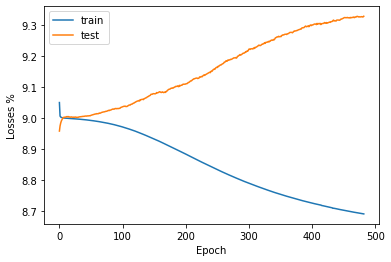

In [59]:
plt.plot(np.asarray(train_epoch_losses_3_1)*100, label = "train")
plt.plot(np.asarray(test_epoch_losses_3_1)*100, label = "test")
plt.xlabel('Epoch')
plt.ylabel('Losses %')
plt.legend()
plt.show()

### Question 3-2 Number of parameters v.s. Generalization
* Train on MNIST or CIFAR-10
* At least 10 similar-structured models with different amount of parameters
* Record both training and testing, loss and accuracy

Report: 
* Describe your settings of the experiments. (e.g. which task, the 10 or more structures you choose) 
* Plot the figures of both training and testing, loss and accuracy to the number of parameters. 
* Comment your result. 

In [18]:
num_param = []
last_accuray_train = []
last_loss_train = []
last_accuray_test = []
last_loss_test = []

Model1: 16

In [21]:
model_3_2 = ConvNet().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

29034  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.098268
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.082948
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.069791
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.059994


Train set: Accuracy: 42609/60000 71%

Test set: Accuracy: 9179/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034206
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033011
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.031155
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.029639


Train set: Accuracy: 56028/60000 93%

Test set: Accuracy: 9492/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.024744
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.024482
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.023941
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.023398


Train set: Accuracy: 57270/60000 95%

Test set: Accuracy: 9595/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.021564
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.021284
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.021053
Train Epoch: 4 [57

Model 2: 12


In [22]:
# https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*24, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [23]:
model_3_2 = ConvNet2().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

19378  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.099998
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.081974
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.069993
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.060844


Train set: Accuracy: 41554/60000 69%

Test set: Accuracy: 9034/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.037020
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.034603
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.032796
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.031331


Train set: Accuracy: 55681/60000 93%

Test set: Accuracy: 9434/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.027380
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.026407
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.025942
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.025388


Train set: Accuracy: 56860/60000 95%

Test set: Accuracy: 9535/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.023163
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.023196
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.023019
Train Epoch: 4 [57

Model 3: 24

In [24]:
# https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 48, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*48, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [26]:
model_3_2 = ConvNet3().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

53146  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.102211
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.083278
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.070531
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.060770


Train set: Accuracy: 43861/60000 73%

Test set: Accuracy: 9120/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.035441
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033862
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.032024
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.030404


Train set: Accuracy: 55714/60000 93%

Test set: Accuracy: 9482/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.025959
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.025091
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.024447
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.023772


Train set: Accuracy: 57059/60000 95%

Test set: Accuracy: 9591/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.021984
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.021427
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.021097
Train Epoch: 4 [57

Model 4: 1x32, kernel=5

In [27]:
# https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet4(nn.Module):
    def __init__(self):
        super(ConvNet4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*64, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [28]:
model_3_2 = ConvNet4().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

83658  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.099274
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.081436
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.069169
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.059605


Train set: Accuracy: 44915/60000 75%

Test set: Accuracy: 9175/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033217
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.032537
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.030681
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.029090


Train set: Accuracy: 56081/60000 93%

Test set: Accuracy: 9518/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.024008
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.023841
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.023255
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.022647


Train set: Accuracy: 57300/60000 96%

Test set: Accuracy: 9639/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020451
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.020421
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.020122
Train Epoch: 4 [57

Model 5: 1x42

In [36]:
class ConvNet5(nn.Module):
    def __init__(self):
        super(ConvNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 42, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(42),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(42, 84, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*84, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [37]:
model_3_2 = ConvNet5().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

130798  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.100424
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.082125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.069541
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.059627


Train set: Accuracy: 45003/60000 75%

Test set: Accuracy: 9159/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.031348
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.031522
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.029671
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.028049


Train set: Accuracy: 56158/60000 94%

Test set: Accuracy: 9504/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022653
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.022765
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.022207
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.021623


Train set: Accuracy: 57388/60000 96%

Test set: Accuracy: 9615/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019850
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.019507
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.019245
Train Epoch: 4 [5

Model 6: 1x50

In [38]:
class ConvNet6(nn.Module):
    def __init__(self):
        super(ConvNet6, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*100, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [39]:
model_3_2 = ConvNet6().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

175710  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.098279
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.079630
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.066914
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.057506


Train set: Accuracy: 45925/60000 77%

Test set: Accuracy: 9201/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.032731
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.031065
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.029354
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027889


Train set: Accuracy: 56270/60000 94%

Test set: Accuracy: 9524/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.023491
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.022952
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.022404
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.021855


Train set: Accuracy: 57414/60000 96%

Test set: Accuracy: 9642/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019648
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.019672
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.019377
Train Epoch: 4 [5

model 7: 60

In [46]:
class ConvNet7(nn.Module):
    def __init__(self):
        super(ConvNet7, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 60, kernel_size=6, stride=1, padding=2),
            nn.BatchNorm2d(60),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(60, 120, kernel_size=6, stride=1, padding=2),
            nn.BatchNorm2d(120),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(6*6*120, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [47]:
model_3_2 = ConvNet7().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

305110  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.100566
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.081046
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.068674
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.059020


Train set: Accuracy: 45780/60000 76%

Test set: Accuracy: 9194/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033833
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.031429
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.029473
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027811


Train set: Accuracy: 56224/60000 94%

Test set: Accuracy: 9525/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.023396
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.022523
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.021923
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.021317


Train set: Accuracy: 57401/60000 96%

Test set: Accuracy: 9626/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019357
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.019141
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.018858
Train Epoch: 4 [5

Model 8: 70

In [48]:
class ConvNet8(nn.Module):
    def __init__(self):
        super(ConvNet8, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 70, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(70),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(70, 140, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(140),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*140, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [49]:
model_3_2 = ConvNet8().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

315990  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.094083
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.078559
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.066269
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.057309


Train set: Accuracy: 46087/60000 77%

Test set: Accuracy: 9149/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.032901
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.031436
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.029525
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027928


Train set: Accuracy: 56164/60000 94%

Test set: Accuracy: 9502/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022840
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.022605
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.022073
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.021528


Train set: Accuracy: 57377/60000 96%

Test set: Accuracy: 9629/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019043
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.019355
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.019115
Train Epoch: 4 [5

model 9: 80

In [50]:
# https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet9(nn.Module):
    def __init__(self):
        super(ConvNet9, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 80, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(80, 160, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*160, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [51]:
model_3_2 = ConvNet9().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

401130  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.099180
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.080026
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067094
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.057586


Train set: Accuracy: 47401/60000 79%

Test set: Accuracy: 9276/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.033060
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.030754
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.028894
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027301


Train set: Accuracy: 56460/60000 94%

Test set: Accuracy: 9550/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022911
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.022242
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.021670
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.021056


Train set: Accuracy: 57511/60000 96%

Test set: Accuracy: 9635/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019148
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.018988
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.018696
Train Epoch: 4 [5

model 10: 85

In [55]:
class ConvNet10(nn.Module):
    def __init__(self):
        super(ConvNet10, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 85, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(85),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(85, 170, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(170),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*170, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [56]:
model_3_2 = ConvNet10().to(device)
model_3_2.apply(init_weights)
loss = nn.MSELoss()
optim_3_2 = SGD(model_3_2.parameters(), lr =learning_rate, momentum = momentum)

train_iter_losses_3_2_temp = []
train_epoch_losses_3_2_temp = []
train_epoch_accuracy_3_2_temp = []

test_epoch_accuracy_3_2_temp = []
test_epoch_losses_3_2_temp = []

print(sum(p.numel() for p in model_3_2.parameters())," parameters")

num_param.append(sum(p.numel() for p in model_3_2.parameters()))

n_epochs = 6
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_2, loss, optim_3_2, epoch, 
     train_iter_losses_3_2_temp, train_epoch_losses_3_2_temp, train_epoch_accuracy_3_2_temp)
  test(test_dl, model_3_2, loss, 
        test_epoch_losses_3_2_temp, test_epoch_accuracy_3_2_temp)
    
last_accuray_train.append(train_epoch_accuracy_3_2_temp[-1])
last_loss_train.append(train_epoch_losses_3_2_temp[-1])
last_accuray_test.append(test_epoch_accuracy_3_2_temp[-1])
last_loss_test.append(test_epoch_losses_3_2_temp[-1])

447450  parameters
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.097464
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.078352
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.065474
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.056390


Train set: Accuracy: 48370/60000 81%

Test set: Accuracy: 9267/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.032166
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.031123
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.029368
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.027817


Train set: Accuracy: 56396/60000 94%

Test set: Accuracy: 9564/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022985
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.022622
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.022039
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.021455


Train set: Accuracy: 57491/60000 96%

Test set: Accuracy: 9645/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.019949
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.019238
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.018958
Train Epoch: 4 [5

Plot

Text(0.5, 1.0, 'Losses vs # of Parameters')

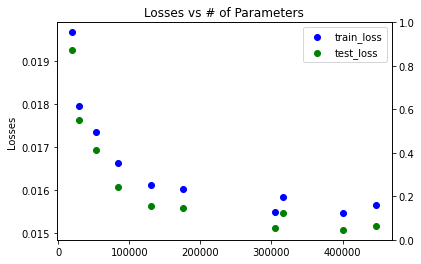

In [70]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(num_param, last_loss_train, color ='b', label = "train_loss")
ax1.scatter(num_param, last_loss_test, color = 'g',  label = "test_loss")

#ax2.scatter(num_param, last_accuray_train, color = 'b',label = "train_accuracy")
#ax2.scatter(num_param, last_accuray_test, color='b', marker = '*', label = "test_accuracy")


ax1.legend()
plt.xlabel('# Parameters')
#plt.ylabel('Losses')
ax1.set_ylabel('Losses')
#ax2.set_ylabel('Accuracy %', color='b')
plt.title('Losses vs # of Parameters')




Text(0.5, 1.0, 'Accuracy vs # of Parameters')

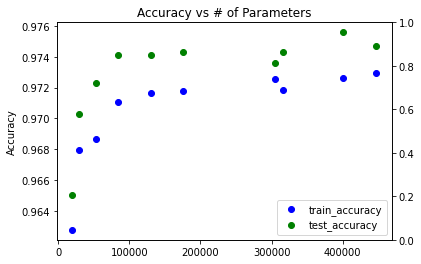

In [71]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(num_param, last_accuray_train, color ='b', label = "train_accuracy")
ax1.scatter(num_param, last_accuray_test, color = 'g',  label = "test_accuracy")

#ax2.scatter(num_param, last_accuray_train, color = 'b',label = "train_accuracy")
#ax2.scatter(num_param, last_accuray_test, color='b', marker = '*', label = "test_accuracy")


ax1.legend()
plt.xlabel('# Parameters')
#plt.ylabel('Losses')
ax1.set_ylabel('Accuracy')
#ax2.set_ylabel('Accuracy %', color='b')
plt.title('Accuracy vs # of Parameters')


### Question 3-3 Flatness v.s. Generalization
#### Part1
* Visualize the line between two trained models

Requirement:
* Train two models (m1 and m2) with different training approach. (e.g. batch size 64 and 1024)
* Record the loss and accuracy of the model which is linear interpolation between m1 and m2.
* ???, where     is the interpolation ratio,      is the parameter of the model.

Report: 
* Describe the settings of the experiments (e.g. which task, what training approaches) 
* Plot the figures of both training and testing, loss and accuracy to the number of interpolation ratio. 
* Comment your result.

In [263]:
train_dl2 = DataLoader(train_ds, batch_size=1024)

Model1 `model_3_3_64`: batchsize = 64, learning rate = 1e-2

In [269]:
model_3_3_64 = ConvNet()
model_3_3_64.apply(init_weights2)
loss = nn.MSELoss()
optim_3_3_64 = SGD(model_3_3_64.parameters(), lr =1e-2, momentum = momentum)

train_iter_losses_3_3_temp = []
train_epoch_losses_3_3_temp = []
train_epoch_accuracy_3_3_temp = []

test_epoch_accuracy_3_3_temp = []
test_epoch_losses_3_3_temp = []

n_epochs = 2
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_3_64, loss, optim_3_3_64, epoch, 
     train_iter_losses_3_3_temp, train_epoch_losses_3_3_temp, train_epoch_accuracy_3_3_temp)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.711796
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.152088
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.097894
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.077760


Train set: Accuracy: 49672/60000 83%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042476
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033391
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.032197
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.031340


Train set: Accuracy: 55357/60000 92%


Model2 `model_3_3_1024`: batchsize = 1024, learning rate = 1e-2

In [270]:
model_3_3_1024 = ConvNet()
model_3_3_1024.apply(init_weights2)
loss = nn.MSELoss()
optim_3_3_1024 = SGD(model_3_3_1024.parameters(), lr =1e-2, momentum = momentum)

train_iter_losses_3_3_temp = []
train_epoch_losses_3_3_temp = []
train_epoch_accuracy_3_3_temp = []

test_epoch_accuracy_3_3_temp = []
test_epoch_losses_3_3_temp = []

n_epochs = 2
for epoch in range(1, n_epochs + 1):
  fit(train_dl2, model_3_3_1024, loss, optim_3_3_1024, epoch, 
     train_iter_losses_3_3_temp, train_epoch_losses_3_3_temp, train_epoch_accuracy_3_3_temp)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318373


Train set: Accuracy: 28093/60000 47%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.080499


Train set: Accuracy: 42115/60000 70%


Model3 `model_3_3_64_2`: batchsize = 64, learning rate = 1e-3

In [271]:
model_3_3_64_2 = ConvNet()
model_3_3_64_2.apply(init_weights2)
loss = nn.MSELoss()
optim_3_3_64_2 = SGD(model_3_3_64_2.parameters(), lr =1e-3, momentum = momentum)

train_iter_losses_3_3_temp = []
train_epoch_losses_3_3_temp = []
train_epoch_accuracy_3_3_temp = []

test_epoch_accuracy_3_3_temp = []
test_epoch_losses_3_3_temp = []

n_epochs = 2
for epoch in range(1, n_epochs + 1):
  fit(train_dl, model_3_3_64_2, loss, optim_3_3_64_2, epoch, 
     train_iter_losses_3_3_temp, train_epoch_losses_3_3_temp, train_epoch_accuracy_3_3_temp)

Train Epoch: 1 [0/60000 (0%)]	Loss: 4.222276
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.273458
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.192883
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.157339


Train set: Accuracy: 34885/60000 58%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.075935
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.072308
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.068964
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.066016


Train set: Accuracy: 47278/60000 79%


Model4 `model_3_3_1024_2`: batchsize = 1024, learning rate = 1e-3

In [272]:
model_3_3_1024_2 = ConvNet()
model_3_3_1024_2.apply(init_weights2)
loss = nn.MSELoss()
optim_3_3_1024_2 = SGD(model_3_3_1024_2.parameters(), lr =1e-3, momentum = momentum)

train_iter_losses_3_3_temp = []
train_epoch_losses_3_3_temp = []
train_epoch_accuracy_3_3_temp = []

test_epoch_accuracy_3_3_temp = []
test_epoch_losses_3_3_temp = []

n_epochs = 2
for epoch in range(1, n_epochs + 1):
  fit(train_dl2, model_3_3_1024_2, loss, optim_3_3_1024_2, epoch, 
     train_iter_losses_3_3_temp, train_epoch_losses_3_3_temp, train_epoch_accuracy_3_3_temp)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295811


Train set: Accuracy: 10609/60000 18%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.284619


Train set: Accuracy: 18820/60000 31%


interpolation between m1 and m2, m3 and m4

In [441]:
def test_alpha(testset, model, alpha, p_m1, p_m2,loss):
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  
        model.layer1[0].weight = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[0]+alpha*p_m2[0])
        model.layer1[0].bias = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[1]+alpha*p_m2[1])
        model.layer1[1].weight = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[2]+alpha*p_m2[2])
        model.layer1[1].bias = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[3]+alpha*p_m2[3])
        model.layer2[0].weight = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[4]+alpha*p_m2[4])
        model.layer2[0].bias = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[5]+alpha*p_m2[5])
        model.layer2[1].weight = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[6]+alpha*p_m2[6])
        model.layer2[1].bias = torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[7]+alpha*p_m2[7])
        model.fc.weight =  torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[8]+alpha*p_m2[8])
        model.fc.bias =  torch.nn.parameter.Parameter(
            (1-alpha)*p_m1[9]+alpha*p_m2[9])
 
        #for i in range(0,len(list(p_m1))):
        #    list(model.parameters())[i] = (1-alpha)*p_m1[i]+alpha*p_m2[i]
            
        for data, target in testset:
            output = model(data)
            ls = loss(output, target)
            running_loss += ls.item()
            _, original = torch.max(target, 1)
            _, predicted =  torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==original).sum().item()

    return(running_loss/len(testset), correct/total)

In [464]:
# lr = 1e-2
model_new = type(model_3_3_64)() 
model_new.load_state_dict(model_3_3_64.state_dict()) # copy weights and stuff

loss = nn.MSELoss()
p_m1 = list(model_3_3_64.parameters())
p_m2 = list(model_3_3_1024.parameters())

losses_train1 = dict()
losses_test1 = dict()
accu_train1 = dict()
accu_test1 = dict()

for alpha in np.arange(-1,2.2,0.2):
    losses_train1[alpha], accu_train1[alpha] = test_alpha(train_dl, 
                                    model_new, alpha, p_m1, p_m2, loss)
    losses_test1[alpha], accu_test1[alpha] = test_alpha(test_dl, 
                                    model_new, alpha, p_m1, p_m2, loss)


In [444]:
# lr = 1e-3
model_new2 = type(model_3_3_64_2)() 
model_new2.load_state_dict(model_3_3_64_2.state_dict()) # copy weights and stuff

loss = nn.MSELoss()
p_m1 = list(model_3_3_64_2.parameters())
p_m2 = list(model_3_3_1024_2.parameters())

losses_train2 = dict()
losses_test2 = dict()
accu_train2 = dict()
accu_test2 = dict()

for alpha in np.arange(-1,2.2,0.2):
    losses_train2[alpha], accu_train2[alpha]= test_alpha(train_dl, model_new2, alpha, p_m1, p_m2, loss)
    losses_test2[alpha], accu_test2[alpha]= test_alpha(test_dl, model_new2, alpha, p_m1, p_m2, loss)

Plot

In [460]:
def get_spline(x,y):
    x, y = np.asarray(x), np.asarray(y)
    xnew = np.linspace(x.min(), x.max(), 300) 
    spl = make_interp_spline(x, y, k=3)  # type: BSpline
    smoothy= spl(xnew)
    return(xnew, smoothy)

Text(0.5, 1.0, 'Learning rate = 1e-2')

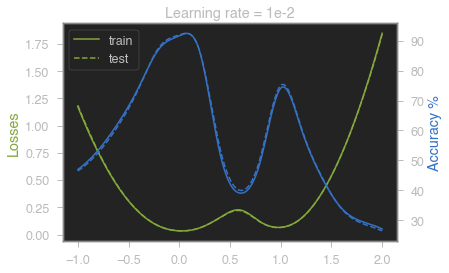

In [471]:
spline_ls_tr = get_spline([*losses_train1.keys()], [*losses_train1.values()])
spline_ls_te = get_spline([*losses_test1.keys()], [*losses_test1.values()])
spline_ac_tr = get_spline([*accu_train1.keys()], [*accu_train1.values()])
spline_ac_te = get_spline([*accu_test1.keys()], [*accu_test1.values()])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(spline_ls_tr[0], spline_ls_tr[1], 'g-', label = "train")
ax1.plot(spline_ls_te[0], spline_ls_te[1], 'g-', linestyle='--', label = "test")
ax2.plot(spline_ac_tr[0], 100*spline_ac_tr[1], 'b-', label = "train")
ax2.plot(spline_ac_te[0], 100*spline_ac_te[1], 'b-', linestyle = '--', label = "train")

ax1.legend()
plt.xlabel('alpha')
#plt.ylabel('Losses')
ax1.set_ylabel('Losses', color='g')
ax2.set_ylabel('Accuracy %', color='b')
plt.title('Learning rate = 1e-2')
#draw_spline([*losses_test1.keys()], [*losses_test1.values()])
#draw_spline([*losses_train1.keys()], [*losses_train1.values()], "train")





Text(0.5, 1.0, 'Learning rate = 1e-3')

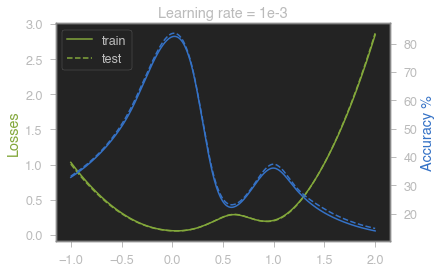

In [465]:
spline_ls2_tr = get_spline([*losses_train2.keys()], [*losses_train2.values()])
spline_ls2_te = get_spline([*losses_test2.keys()], [*losses_test2.values()])
spline_ac2_tr = get_spline([*accu_train2.keys()], [*accu_train2.values()])
spline_ac2_te = get_spline([*accu_test2.keys()], [*accu_test2.values()])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(spline_ls2_tr[0], spline_ls2_tr[1], 'g-', label = "train")
ax1.plot(spline_ls2_te[0], spline_ls2_te[1], 'g-', linestyle='--', label = "test")
ax2.plot(spline_ac2_tr[0], 100*spline_ac2_tr[1], 'b-', label = "train")
ax2.plot(spline_ac2_te[0], 100*spline_ac2_te[1], 'b-', linestyle = '--', label = "train")

ax1.legend()
plt.xlabel('alpha')
#plt.ylabel('Losses')
ax1.set_ylabel('Losses', color='g')
ax2.set_ylabel('Accuracy %', color='b')
plt.title('Learning rate = 1e-3')
#draw_spline([*losses_test1.keys()], [*losses_test1.values()])
#draw_spline([*losses_train1.keys()], [*losses_train1.values()], "train")


#### Part 2
Requirement:  
* Train at least 5 models with different training approach.  
* Record the loss and accuracy of all models.  
* Record the sensitivity of all models.  

Didn't run the following codes